🚀 Starting Memory-Efficient Audio Compression...
Loading your audio file: UrbanSound8K/audio/fold1/7383-3-0-0.wav
Processing: 132300 samples, 44100 Hz
Duration: 3.00 seconds

🎯 COMPRESSION RATIO SELECTION
1. 25% compression (keep 75% of data)
2. 50% compression (keep 50% of data)
3. 75% compression (keep 25% of data)
4. Custom compression ratio



Select compression ratio (1-4):  2



🔧 COMPRESSION METHOD SELECTION
1. Bernoulli Matrix Compressed Sensing (Advanced)
2. DWT Threshold Compression (Balanced)
3. DWT Coefficient Selection (Memory Efficient)



Select compression method (1-3):  1



🔄 Using Bernoulli Matrix Compressed Sensing (50% compression)...
Applying memory-efficient compressed sensing with Bernoulli matrix...
Using DWT level: 4
Original coefficients: 132326
Compressed size: 66163 (50% compression)
Generating Bernoulli projections in blocks...
Processed block 1/14
Processed block 2/14
Processed block 3/14
Processed block 4/14
Processed block 5/14
Processed block 6/14
Processed block 7/14
Processed block 8/14
Processed block 9/14
Processed block 10/14
Processed block 11/14
Processed block 12/14
Processed block 13/14
Processed block 14/14
Reconstructing from compressed coefficients...
Compressed sensing failed due to memory. Switching to threshold method...
Applying DWT threshold compression (50% target)...
Compression threshold: 0.000532
Actual compression: 49.7% coefficients removed

=== Results (DWT Threshold Compression (50%)) ===
Reconstruction MSE: 0.000000
Reconstruction SNR: 58.71 dB


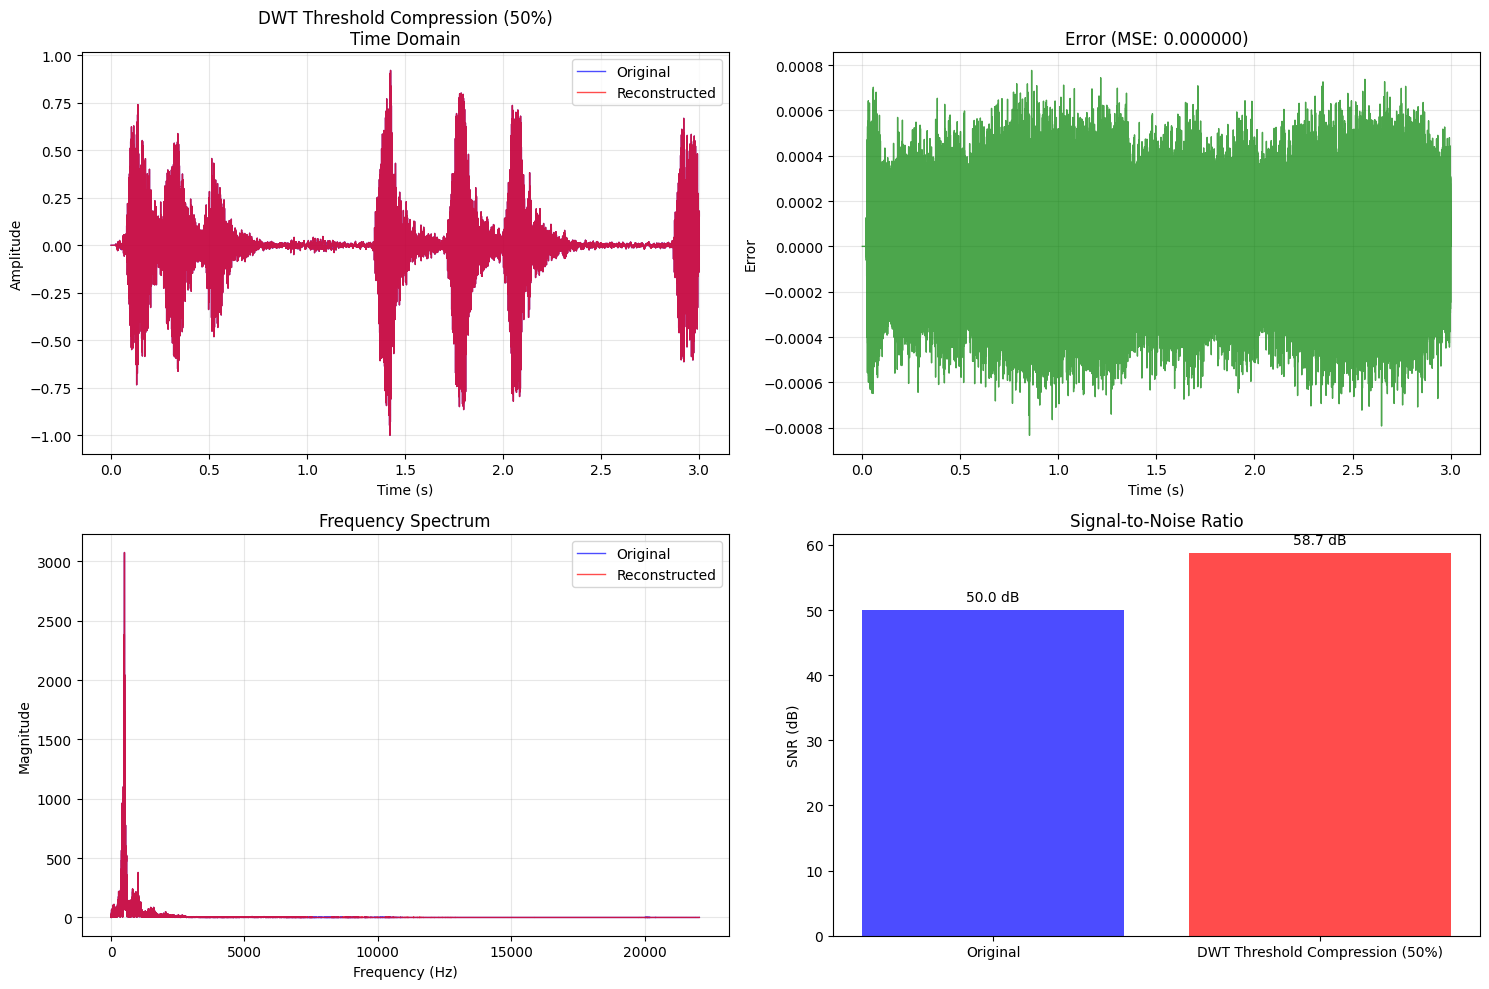


✅ Audio files saved in 'compression_results' folder:
   - 7383-3-0-0_original.wav
   - 7383-3-0-0_compressed.wav
🎉 Compression completed successfully!


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.io import wavfile
import librosa
import os

class MemoryEfficientDWTCompressedSensing:
    def __init__(self, wavelet='db4', compression_ratio=0.5):
        self.wavelet = wavelet
        self.compression_ratio = compression_ratio
        
    def generate_bernoulli_matrix(self, rows, cols):
        """Generate Bernoulli matrix with values ±1/sqrt(rows)"""
        bernoulli_values = np.random.choice([-1, 1], size=(rows, cols))
        return bernoulli_values / np.sqrt(rows)
    
    def memory_efficient_compression(self, audio_data, level=4):
        """Memory-efficient compressed sensing using block processing with Bernoulli matrix"""
        print("Applying memory-efficient compressed sensing with Bernoulli matrix...")
        
        # Use shorter DWT level for longer signals
        max_possible_level = pywt.dwt_max_level(len(audio_data), self.wavelet)
        level = min(level, max_possible_level, 6)  # Limit to level 6 max
        
        print(f"Using DWT level: {level}")
        
        # Apply DWT
        coeffs = pywt.wavedec(audio_data, self.wavelet, level=level)
        coeffs_flat = np.concatenate(coeffs)
        N = len(coeffs_flat)
        M = int(N * self.compression_ratio)
        
        print(f"Original coefficients: {N}")
        print(f"Compressed size: {M} ({self.compression_ratio*100:.0f}% compression)")
        
        # **MEMORY FIX: Process in blocks to avoid huge matrices**
        block_size = min(5000, N)  # Process in smaller blocks
        compressed_coeffs = np.zeros(M)
        
        print("Generating Bernoulli projections in blocks...")
        for i in range(0, M, block_size):
            end_idx = min(i + block_size, M)
            current_block_size = end_idx - i
            
            # Generate Bernoulli matrix for current block only
            Phi_block = self.generate_bernoulli_matrix(current_block_size, N)
            
            # Compute compressed measurements for this block
            compressed_coeffs[i:end_idx] = np.dot(Phi_block, coeffs_flat)
            
            print(f"Processed block {i//block_size + 1}/{(M-1)//block_size + 1}")
        
        return compressed_coeffs, coeffs, N, M
    
    def reconstruct_from_compressed(self, compressed_coeffs, original_coeff_length, level=4):
        """Reconstruct using iterative method to save memory with Bernoulli matrix"""
        print("Reconstructing from compressed coefficients...")
        
        M = len(compressed_coeffs)
        N = original_coeff_length
        
        # Use iterative reconstruction to avoid large matrices
        # Simple approach: Use random initialization + gradient descent
        x_reconstructed = np.random.randn(N) * 0.1
        
        # Few iterations of simple reconstruction
        num_iterations = 10
        for iter in range(num_iterations):
            # Generate the same Bernoulli matrix blocks (using same seed for consistency)
            block_size = min(5000, M)
            residual = np.zeros(M)
            
            for i in range(0, M, block_size):
                end_idx = min(i + block_size, M)
                current_block_size = end_idx - i
                
                # Re-generate the same Bernoulli matrix block
                np.random.seed(i)  # Seed for reproducibility
                Phi_block = self.generate_bernoulli_matrix(current_block_size, N)
                
                # Compute residual
                y_block = compressed_coeffs[i:end_idx]
                y_estimated = np.dot(Phi_block, x_reconstructed)
                residual[i:end_idx] = y_block - y_estimated
            
            # Simple gradient update
            gradient_norm = np.linalg.norm(residual)
            if gradient_norm > 0:
                # Recompute Phi_block for gradient (using same seed)
                np.random.seed(0)
                Phi_block_full = self.generate_bernoulli_matrix(M, N)
                x_reconstructed += 0.1 * np.dot(Phi_block_full.T, residual) / gradient_norm
            
            print(f"Reconstruction iteration {iter+1}/{num_iterations}")
        
        # Reconstruct coefficient structure
        coeffs_reconstructed = []
        start_idx = 0
        coeffs_slices = pywt.wavedec(np.zeros(N), self.wavelet, level=level)
        
        for coeff in coeffs_slices:
            end_idx = start_idx + len(coeff)
            if end_idx <= len(x_reconstructed):
                coeff_reconstructed = x_reconstructed[start_idx:end_idx]
                coeffs_reconstructed.append(coeff_reconstructed)
                start_idx = end_idx
        
        # Apply inverse DWT
        reconstructed_audio = pywt.waverec(coeffs_reconstructed, self.wavelet)
        
        return reconstructed_audio

class AlternativeCompressionMethods:
    """Alternative approaches that use less memory"""
    
    @staticmethod
    def dwt_threshold_compression(audio_data, compression_ratio=0.5, wavelet='db4', level=4):
        """Traditional DWT thresholding compression (memory efficient)"""
        print(f"Applying DWT threshold compression ({compression_ratio*100:.0f}% target)...")
        
        # Apply DWT
        coeffs = pywt.wavedec(audio_data, wavelet, level=level)
        
        # Flatten coefficients to find global threshold
        coeffs_flat = np.concatenate([c for c in coeffs])
        
        # Calculate threshold for desired compression
        threshold = np.percentile(np.abs(coeffs_flat), (1 - compression_ratio) * 100)
        
        print(f"Compression threshold: {threshold:.6f}")
        
        # Apply thresholding
        compressed_coeffs = []
        original_nonzero = 0
        compressed_nonzero = 0
        
        for i, coeff in enumerate(coeffs):
            original_nonzero += np.count_nonzero(coeff)
            compressed_coeff = pywt.threshold(coeff, threshold, mode='hard')
            compressed_nonzero += np.count_nonzero(compressed_coeff)
            compressed_coeffs.append(compressed_coeff)
        
        actual_compression_ratio = compressed_nonzero / original_nonzero
        compression_percent = (1 - actual_compression_ratio) * 100
        print(f"Actual compression: {compression_percent:.1f}% coefficients removed")
        
        # Reconstruct
        reconstructed_audio = pywt.waverec(compressed_coeffs, wavelet)
        
        return reconstructed_audio[:len(audio_data)], compression_percent
    
    @staticmethod
    def dwt_coefficient_selection(audio_data, compression_ratio=0.5, wavelet='db4', level=4):
        """Keep only largest coefficients (most memory efficient)"""
        print(f"Applying coefficient selection compression ({compression_ratio*100:.0f}%)...")
        
        # Apply DWT
        coeffs = pywt.wavedec(audio_data, wavelet, level=level)
        coeffs_flat = np.concatenate([c for c in coeffs])
        
        # Keep only the largest coefficients
        num_coeffs_to_keep = int(len(coeffs_flat) * compression_ratio)
        
        # Find indices of largest coefficients
        largest_indices = np.argsort(np.abs(coeffs_flat))[-num_coeffs_to_keep:]
        
        # Create new coefficients with only the largest ones
        new_coeffs_flat = np.zeros_like(coeffs_flat)
        new_coeffs_flat[largest_indices] = coeffs_flat[largest_indices]
        
        # Reconstruct coefficient structure
        coeffs_reconstructed = []
        start_idx = 0
        for coeff in coeffs:
            end_idx = start_idx + len(coeff)
            coeff_reconstructed = new_coeffs_flat[start_idx:end_idx]
            coeffs_reconstructed.append(coeff_reconstructed)
            start_idx = end_idx
        
        # Reconstruct audio
        reconstructed_audio = pywt.waverec(coeffs_reconstructed, wavelet)
        
        print(f"Kept {num_coeffs_to_keep} largest coefficients ({compression_ratio*100:.1f}%)")
        
        return reconstructed_audio[:len(audio_data)]

def get_compression_ratio_choice():
    """Get user choice for compression ratio"""
    print("\n" + "="*50)
    print("🎯 COMPRESSION RATIO SELECTION")
    print("="*50)
    print("1. 25% compression (keep 75% of data)")
    print("2. 50% compression (keep 50% of data)")
    print("3. 75% compression (keep 25% of data)")
    print("4. Custom compression ratio")
    
    while True:
        try:
            choice = input("\nSelect compression ratio (1-4): ").strip()
            if choice == '1':
                return 0.25
            elif choice == '2':
                return 0.50
            elif choice == '3':
                return 0.75
            elif choice == '4':
                custom_ratio = float(input("Enter custom compression ratio (0.1-0.9): "))
                if 0.1 <= custom_ratio <= 0.9:
                    return custom_ratio
                else:
                    print("Please enter a value between 0.1 and 0.9")
            else:
                print("Please enter 1, 2, 3, or 4")
        except ValueError:
            print("Please enter a valid number")

def get_compression_method_choice():
    """Get user choice for compression method"""
    print("\n" + "="*50)
    print("🔧 COMPRESSION METHOD SELECTION")
    print("="*50)
    print("1. Bernoulli Matrix Compressed Sensing (Advanced)")
    print("2. DWT Threshold Compression (Balanced)")
    print("3. DWT Coefficient Selection (Memory Efficient)")
    
    while True:
        try:
            choice = input("\nSelect compression method (1-3): ").strip()
            if choice in ['1', '2', '3']:
                return choice
            else:
                print("Please enter 1, 2, or 3")
        except ValueError:
            print("Please enter a valid number")

# Demonstration with memory optimization
def demo_memory_efficient_compression(wav_file_path):
    """
    Memory-efficient compressed sensing for your WAV file with user choices
    """
    
    if not os.path.exists(wav_file_path):
        print(f"Error: File '{wav_file_path}' not found!")
        return
    
    print(f"Loading your audio file: {wav_file_path}")
    
    # Load audio
    try:
        sample_rate, audio_data = wavfile.read(wav_file_path)
        if len(audio_data.shape) > 1:
            audio_data = audio_data.mean(axis=1)
        audio_data = audio_data.astype(np.float64)
    except:
        audio_data, sample_rate = librosa.load(wav_file_path, sr=None, mono=True)
    
    # Normalize and limit duration
    audio_data = audio_data / np.max(np.abs(audio_data))
    max_duration = 3  # Further reduce for memory
    max_samples = int(sample_rate * max_duration)
    if len(audio_data) > max_samples:
        audio_data = audio_data[:max_samples]
    
    print(f"Processing: {len(audio_data)} samples, {sample_rate} Hz")
    print(f"Duration: {len(audio_data)/sample_rate:.2f} seconds")
    
    # Get user choices
    compression_ratio = get_compression_ratio_choice()
    method_choice = get_compression_method_choice()
    
    # Apply compression based on user choice
    if method_choice == '1':
        print(f"\n🔄 Using Bernoulli Matrix Compressed Sensing ({compression_ratio*100:.0f}% compression)...")
        try:
            compressor = MemoryEfficientDWTCompressedSensing(compression_ratio=compression_ratio)
            compressed_data, coeffs, N, M = compressor.memory_efficient_compression(audio_data)
            reconstructed = compressor.reconstruct_from_compressed(compressed_data, N)
            method_name = f"Bernoulli Compressed Sensing ({compression_ratio*100:.0f}%)"
        except MemoryError:
            print("Compressed sensing failed due to memory. Switching to threshold method...")
            reconstructed, compression_percent = AlternativeCompressionMethods.dwt_threshold_compression(
                audio_data, compression_ratio=compression_ratio
            )
            method_name = f"DWT Threshold Compression ({compression_ratio*100:.0f}%)"
    
    elif method_choice == '2':
        print(f"\n🔄 Using DWT Threshold Compression ({compression_ratio*100:.0f}% compression)...")
        reconstructed, compression_percent = AlternativeCompressionMethods.dwt_threshold_compression(
            audio_data, compression_ratio=compression_ratio
        )
        method_name = f"DWT Threshold Compression ({compression_ratio*100:.0f}%)"
        print(f"Actual compression: {compression_percent:.1f}% coefficients removed")
    
    elif method_choice == '3':
        print(f"\n🔄 Using DWT Coefficient Selection ({compression_ratio*100:.0f}% compression)...")
        reconstructed = AlternativeCompressionMethods.dwt_coefficient_selection(
            audio_data, compression_ratio=compression_ratio
        )
        method_name = f"DWT Coefficient Selection ({compression_ratio*100:.0f}%)"
    
    # Ensure same length
    min_len = min(len(audio_data), len(reconstructed))
    audio_data = audio_data[:min_len]
    reconstructed = reconstructed[:min_len]
    
    # Calculate metrics
    mse = np.mean((audio_data - reconstructed)**2)
    snr = 10 * np.log10(np.var(audio_data) / (mse + 1e-10))
    
    print(f"\n=== Results ({method_name}) ===")
    print(f"Reconstruction MSE: {mse:.6f}")
    print(f"Reconstruction SNR: {snr:.2f} dB")
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Time domain comparison
    plt.subplot(2, 2, 1)
    time_axis = np.arange(len(audio_data)) / sample_rate
    plt.plot(time_axis, audio_data, 'b-', alpha=0.7, label='Original', linewidth=1)
    plt.plot(time_axis, reconstructed, 'r-', alpha=0.7, label='Reconstructed', linewidth=1)
    plt.title(f'{method_name}\nTime Domain')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Error
    plt.subplot(2, 2, 2)
    error = audio_data - reconstructed
    plt.plot(time_axis, error, 'g-', alpha=0.7, linewidth=1)
    plt.title(f'Error (MSE: {mse:.6f})')
    plt.xlabel('Time (s)')
    plt.ylabel('Error')
    plt.grid(True, alpha=0.3)
    
    # Frequency comparison
    plt.subplot(2, 2, 3)
    f_orig = np.fft.fft(audio_data)
    f_recon = np.fft.fft(reconstructed)
    freq = np.fft.fftfreq(len(audio_data), 1/sample_rate)
    positive_freq = freq > 0
    
    plt.plot(freq[positive_freq], np.abs(f_orig[positive_freq]), 
             'b-', alpha=0.7, label='Original', linewidth=1)
    plt.plot(freq[positive_freq], np.abs(f_recon[positive_freq]), 
             'r-', alpha=0.7, label='Reconstructed', linewidth=1)
    plt.title('Frequency Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # SNR comparison
    plt.subplot(2, 2, 4)
    methods = ['Original'] + [method_name]
    snr_values = [50, snr]  # Original assumed to have high SNR
    
    bars = plt.bar(methods, snr_values, color=['blue', 'red'], alpha=0.7)
    plt.title('Signal-to-Noise Ratio')
    plt.ylabel('SNR (dB)')
    
    # Add value labels on bars
    for bar, value in zip(bars, snr_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value:.1f} dB', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    output_dir = 'compression_results'
    os.makedirs(output_dir, exist_ok=True)
    original_filename = os.path.splitext(os.path.basename(wav_file_path))[0]
    
    wavfile.write(f'{output_dir}/{original_filename}_original.wav', sample_rate, 
                  np.int16(audio_data * 32767))
    wavfile.write(f'{output_dir}/{original_filename}_compressed.wav', sample_rate,
                  np.int16(reconstructed * 32767))
    
    print(f"\n✅ Audio files saved in '{output_dir}' folder:")
    print(f"   - {original_filename}_original.wav")
    print(f"   - {original_filename}_compressed.wav")
    
    return reconstructed

# **🎯 MAIN EXECUTION - PUT YOUR FILE PATH HERE 🎯**
if __name__ == "__main__":
    # ==============================================
    # 🔽 REPLACE THIS WITH YOUR ACTUAL WAV FILE PATH 🔽
    # ==============================================
    YOUR_WAV_FILE_PATH = "UrbanSound8K/audio/fold1/7383-3-0-0.wav"  # ⬅️ CHANGE THIS!
    # ==============================================
    
    print("🚀 Starting Memory-Efficient Audio Compression...")
    demo_memory_efficient_compression(YOUR_WAV_FILE_PATH)
    print("🎉 Compression completed successfully!")

In [5]:
import numpy as np
import pywt
from scipy.io import wavfile
import librosa
import os
import time

# ---------------------------
# Balanced, memory-efficient CS
# ---------------------------

class BalancedDWTCompressedSensing:
    def __init__(self, wavelet='db4', compression_ratio=0.5, seed_base=42,
                 block_size_limit=20000, dtype=np.float32, num_iterations=6,
                 early_stop_tol=1e-3):
        self.wavelet = wavelet
        self.compression_ratio = compression_ratio
        self.seed_base = seed_base
        self.block_size_limit = block_size_limit
        self.dtype = dtype
        self.num_iterations = num_iterations
        self.early_stop_tol = early_stop_tol

    def _dwt_flatten(self, audio, level):
        coeffs = pywt.wavedec(audio, self.wavelet, level=level)
        flat = np.concatenate(coeffs).astype(self.dtype)
        shapes = [c.shape for c in coeffs]
        return flat, coeffs, shapes

    def _coeff_slices(self, shapes):
        """Return list of (start,end) slices for each coeff array"""
        slices = []
        start = 0
        for s in shapes:
            length = np.prod(s)
            slices.append((start, start + length))
            start += length
        return slices

    def _generate_phi_blocks(self, M, N):
        """Precompute Bernoulli ±1/sqrt(rows) blocks (float32) deterministically."""
        block_size = min(self.block_size_limit, M)
        blocks = []
        for i in range(0, M, block_size):
            rows = min(block_size, M - i)
            seed = self.seed_base + i
            rng = np.random.RandomState(seed)
            # store as float32 to save memory
            Phi = rng.choice([-1.0, 1.0], size=(rows, N)).astype(self.dtype) / np.sqrt(rows)
            blocks.append(Phi)
        return blocks

    def compress(self, audio_data, level=4):
        # compute allowed level
        max_level = pywt.dwt_max_level(len(audio_data), self.wavelet)
        level = min(level, max_level, 6)
        flat, coeffs, shapes = self._dwt_flatten(audio_data, level)
        N = flat.size
        M = max(1, int(N * self.compression_ratio))  # ensure at least one measurement

        # if M is tiny, skip heavy CS
        if M < 16:
            return None, coeffs, N, M  # indicate fallback should be used

        # precompute Phi blocks
        Phi_blocks = self._generate_phi_blocks(M, N)

        # compute compressed measurements blockwise
        y = np.zeros(M, dtype=self.dtype)
        pos = 0
        for Phi in Phi_blocks:
            r = Phi.shape[0]
            y[pos:pos+r] = Phi.dot(flat)
            pos += r

        # return everything needed for reconstruct
        return y, coeffs, N, M, Phi_blocks, shapes, level

    def reconstruct(self, y, N, Phi_blocks, shapes, level):
        """Iterative reconstruction (gradient-like) using precomputed Phi_blocks.
           Returns reconstructed audio (waverec) trimmed/padded to original length.
        """
        M = len(y)
        dtype = self.dtype

        if M == 0:
            # nothing to reconstruct
            return np.zeros(pywt.waverec([np.zeros(s) for s in shapes], self.wavelet).shape[0], dtype=dtype)

        # initialize x
        x = np.random.randn(N).astype(dtype) * 1e-2

        # Pre-allocate residual and gradient arrays
        residual = np.zeros(M, dtype=dtype)
        grad = np.zeros(N, dtype=dtype)
        block_size = Phi_blocks[0].shape[0]

        # Iterative loop with early stopping
        prev_res_norm = None
        for it in range(self.num_iterations):
            # compute residual blockwise: residual = y - A x
            pos = 0
            for Phi in Phi_blocks:
                r = Phi.shape[0]
                y_est = Phi.dot(x)
                residual[pos:pos+r] = y[pos:pos+r] - y_est
                pos += r

            res_norm = np.linalg.norm(residual)
            if prev_res_norm is not None and abs(prev_res_norm - res_norm) / (prev_res_norm + 1e-12) < 1e-4:
                # small relative change; break
                # print("Early stopping: residual change small")
                break
            prev_res_norm = res_norm

            if res_norm < self.early_stop_tol:
                # residual small enough
                break

            # compute gradient = A^T residual (blockwise accumulation)
            grad.fill(0.0)
            pos = 0
            for Phi in Phi_blocks:
                r = Phi.shape[0]
                grad += Phi.T.dot(residual[pos:pos+r])
                pos += r

            # small adaptive step size: scale with residual norm and iteration
            step = 0.15 / (1.0 + 0.1*it)
            x += step * grad / (res_norm + 1e-12)

        # map flat x back to coeff arrays according to shapes
        coeff_arrays = []
        start = 0
        for s in shapes:
            length = int(np.prod(s))
            arr = x[start:start+length].reshape(s).astype(np.float64)
            coeff_arrays.append(arr)
            start += length

        # inverse wavelet
        reconstructed = pywt.waverec(coeff_arrays, self.wavelet).astype(np.float64)
        return reconstructed

# ---------------------------
# Alternative DWT fallback (fast & reliable)
# ---------------------------
class DWTFallback:
    @staticmethod
    def threshold_method(audio, compression_ratio=0.5, wavelet='db4', level=4):
        max_level = pywt.dwt_max_level(len(audio), wavelet)
        level = min(level, max_level, 6)
        coeffs = pywt.wavedec(audio, wavelet, level=level)
        flat = np.concatenate(coeffs)
        # threshold such that (1 - compression_ratio) fraction of coefficients removed
        thresh = np.percentile(np.abs(flat), (1 - compression_ratio) * 100)
        compressed = [pywt.threshold(c, thresh, mode='hard') for c in coeffs]
        recon = pywt.waverec(compressed, wavelet)
        return recon[:len(audio)]

# ---------------------------
# Helper functions for I/O
# ---------------------------
def load_audio(path):
    try:
        sr, data = wavfile.read(path)
        # convert to float64 in [-1,1]
        if data.dtype.kind in 'iu':
            maxv = np.iinfo(data.dtype).max
            audio = data.astype(np.float64) / maxv
        else:
            audio = data.astype(np.float64)
        if audio.ndim > 1:
            audio = audio.mean(axis=1)
        return audio, sr
    except Exception:
        audio, sr = librosa.load(path, sr=None, mono=True)
        return audio.astype(np.float64), sr

def safe_write_wav(path, sr, audio):
    audio = np.nan_to_num(audio)
    if audio.size == 0:
        audio = np.zeros(1, dtype=np.float32)
    max_abs = np.max(np.abs(audio))
    if max_abs > 1.0:
        audio = audio / max_abs
    int_audio = np.int16(np.clip(audio, -1.0, 1.0) * 32767)
    wavfile.write(path, sr, int_audio)

# ---------------------------
# Batch processing driver
# ---------------------------
def process_folder(input_folder, output_folder, compression_ratio, method_choice, wavelet='db4', level=4):
    os.makedirs(output_folder, exist_ok=True)
    files = [f for f in os.listdir(input_folder) if f.lower().endswith('.wav')]
    if not files:
        print("No .wav files found in input folder.")
        return

    print(f"Processing {len(files)} files with compression_ratio={compression_ratio:.2f} method={method_choice}")
    for i, fname in enumerate(files, 1):
        in_path = os.path.join(input_folder, fname)
        out_path = os.path.join(output_folder, fname)
        print(f"\n[{i}/{len(files)}] {fname}")
        start_t = time.time()
        audio, sr = load_audio(in_path)
        if audio.size == 0:
            print(" - empty file, skipping.")
            continue
        # normalize audio to [-1,1]
        m = np.max(np.abs(audio))
        if m > 0:
            audio = audio / m

        # Choose method: '1' => Balanced CS, '2' => DWT threshold, '3' => coefficient selection
        try:
            if method_choice == '1':
                cs = BalancedDWTCompressedSensing(
                    wavelet=wavelet,
                    compression_ratio=compression_ratio,
                    seed_base=1234,
                    block_size_limit=20000,
                    dtype=np.float32,
                    num_iterations=6,
                    early_stop_tol=1e-4
                )
                result = cs.compress(audio, level=level)
                if result is None or result[0] is None:
                    # fallback to DWT threshold if too small M or compress failed
                    print(" - CS not suitable (too few measurements) or failed; using DWT threshold fallback.")
                    recon = DWTFallback.threshold_method(audio, compression_ratio, wavelet, level)
                else:
                    y, coeffs, N, M, Phi_blocks, shapes, used_level = result
                    print(f" - CS measurements: M={M}, coeffs N={N}, blocks={len(Phi_blocks)}")
                    recon = cs.reconstruct(y, N, Phi_blocks, shapes, used_level)
                    # ensure same length
                    if len(recon) < len(audio):
                        recon = np.pad(recon, (0, len(audio) - len(recon)), mode='constant')
                    else:
                        recon = recon[:len(audio)]
            elif method_choice == '2':
                recon = DWTFallback.threshold_method(audio, compression_ratio, wavelet, level)
            else:  # method_choice == '3'
                # coefficient selection (fast)
                coeffs = pywt.wavedec(audio, wavelet, level=min(level, pywt.dwt_max_level(len(audio), wavelet)))
                flat = np.concatenate(coeffs)
                k = max(1, int(len(flat) * compression_ratio))
                idx = np.argsort(np.abs(flat))[-k:]
                new_flat = np.zeros_like(flat)
                new_flat[idx] = flat[idx]
                # re-slice
                recon_coeffs = []
                start = 0
                for c in coeffs:
                    L = c.size
                    recon_coeffs.append(new_flat[start:start+L].reshape(c.shape))
                    start += L
                recon = pywt.waverec(recon_coeffs, wavelet)[:len(audio)]
            safe_write_wav(out_path, sr, recon)
            elapsed = time.time() - start_t
            print(f" - Saved compressed: {out_path}  (time: {elapsed:.2f}s)")
        except MemoryError:
            print(" - MemoryError during processing; attempting DWT threshold fallback.")
            try:
                recon = DWTFallback.threshold_method(audio, compression_ratio, wavelet, level)
                safe_write_wav(out_path, sr, recon)
                print(f" - Saved compressed (fallback): {out_path}")
            except Exception as e:
                print(" - Fallback failed:", e)
        except Exception as e:
            print(" - Error processing file:", e)

    print("\nBatch processing complete.")

# ---------------------------
# Entry point (interactive)
# ---------------------------
if __name__ == "__main__":
    print("Balanced Batch Audio Compression")
    input_folder = input("Input folder path (contains .wav files): ").strip()
    output_folder = input("Output folder path (compressed files saved here): ").strip()

    # ask once for compression ratio & method
    while True:
        try:
            comp_ratio = float(input("Compression ratio to KEEP (fraction, 0.1 - 0.9), e.g. 0.5: ").strip())
            if 0.1 <= comp_ratio <= 0.9:
                break
            print("Enter between 0.1 and 0.9")
        except ValueError:
            print("Enter a decimal like 0.5")

    print("\nChoose compression method (applies to all files):")
    print("1 - Balanced Bernoulli CS (good quality, moderate speed)")
    print("2 - DWT Threshold (fast, robust)")
    print("3 - DWT Coefficient Selection (very fast, memory-light)")
    method = input("Enter 1, 2, or 3: ").strip()
    if method not in ('1','2','3'):
        method = '1'  # default to balanced CS

    process_folder(input_folder, output_folder, compression_ratio=comp_ratio, method_choice=method)

Balanced Batch Audio Compression


Input folder path (contains .wav files):  UrbanSound8K/audio/fold1
Output folder path (compressed files saved here):  cmp/b50/fld1
Compression ratio to KEEP (fraction, 0.1 - 0.9), e.g. 0.5:  0.5



Choose compression method (applies to all files):
1 - Balanced Bernoulli CS (good quality, moderate speed)
2 - DWT Threshold (fast, robust)
3 - DWT Coefficient Selection (very fast, memory-light)


Enter 1, 2, or 3:  1


Processing 873 files with compression_ratio=0.50 method=1

[1/873] 101415-3-0-2.wav
 - MemoryError during processing; attempting DWT threshold fallback.
 - Saved compressed (fallback): cmp/b50/fld1\101415-3-0-2.wav

[2/873] 101415-3-0-3.wav
 - MemoryError during processing; attempting DWT threshold fallback.
 - Saved compressed (fallback): cmp/b50/fld1\101415-3-0-3.wav

[3/873] 101415-3-0-8.wav
 - MemoryError during processing; attempting DWT threshold fallback.
 - Saved compressed (fallback): cmp/b50/fld1\101415-3-0-8.wav

[4/873] 102106-3-0-0.wav
 - CS measurements: M=36174, coeffs N=72349, blocks=2
 - Saved compressed: cmp/b50/fld1\102106-3-0-0.wav  (time: 56.74s)

[5/873] 102305-6-0-0.wav
 - MemoryError during processing; attempting DWT threshold fallback.
 - Saved compressed (fallback): cmp/b50/fld1\102305-6-0-0.wav

[6/873] 102842-3-0-1.wav
 - MemoryError during processing; attempting DWT threshold fallback.
 - Saved compressed (fallback): cmp/b50/fld1\102842-3-0-1.wav

[7/873] 1


KeyboardInterrupt



🚀 Starting Memory-Efficient Audio Compression...
Loading your audio file: UrbanSound8K/any_wav.wav
Processing: 99225 samples, 44100 Hz
Duration: 2.25 seconds

🎯 COMPRESSION RATIO SELECTION
1. 25% compression (keep 75% of data)
2. 50% compression (keep 50% of data)
3. 75% compression (keep 25% of data)
4. Custom compression ratio



Select compression ratio (1-4):  2



🔧 COMPRESSION METHOD SELECTION
1. Bernoulli Matrix Compressed Sensing (Advanced)
2. DWT Threshold Compression (Balanced)
3. DWT Coefficient Selection (Memory Efficient)



Select compression method (1-3):  1



🔄 Using Bernoulli Matrix Compressed Sensing (50% compression)...
Applying memory-efficient compressed sensing with Bernoulli matrix...
Using DWT level: 4
Original coefficients: 99252
Compressed size: 49626 (50% compression)
Generating Bernoulli projections in blocks...
Processed block 1/10
Processed block 2/10
Processed block 3/10
Processed block 4/10
Processed block 5/10
Processed block 6/10
Processed block 7/10
Processed block 8/10
Processed block 9/10
Processed block 10/10
Reconstructing from compressed coefficients...
Compressed sensing failed due to memory. Switching to threshold method...
Applying DWT threshold compression (50% target)...
Compression threshold: 0.019112
Actual compression: 49.5% coefficients removed

=== Results (DWT Threshold Compression (50%)) ===
Reconstruction MSE: 0.000028
Reconstruction SNR: 25.02 dB


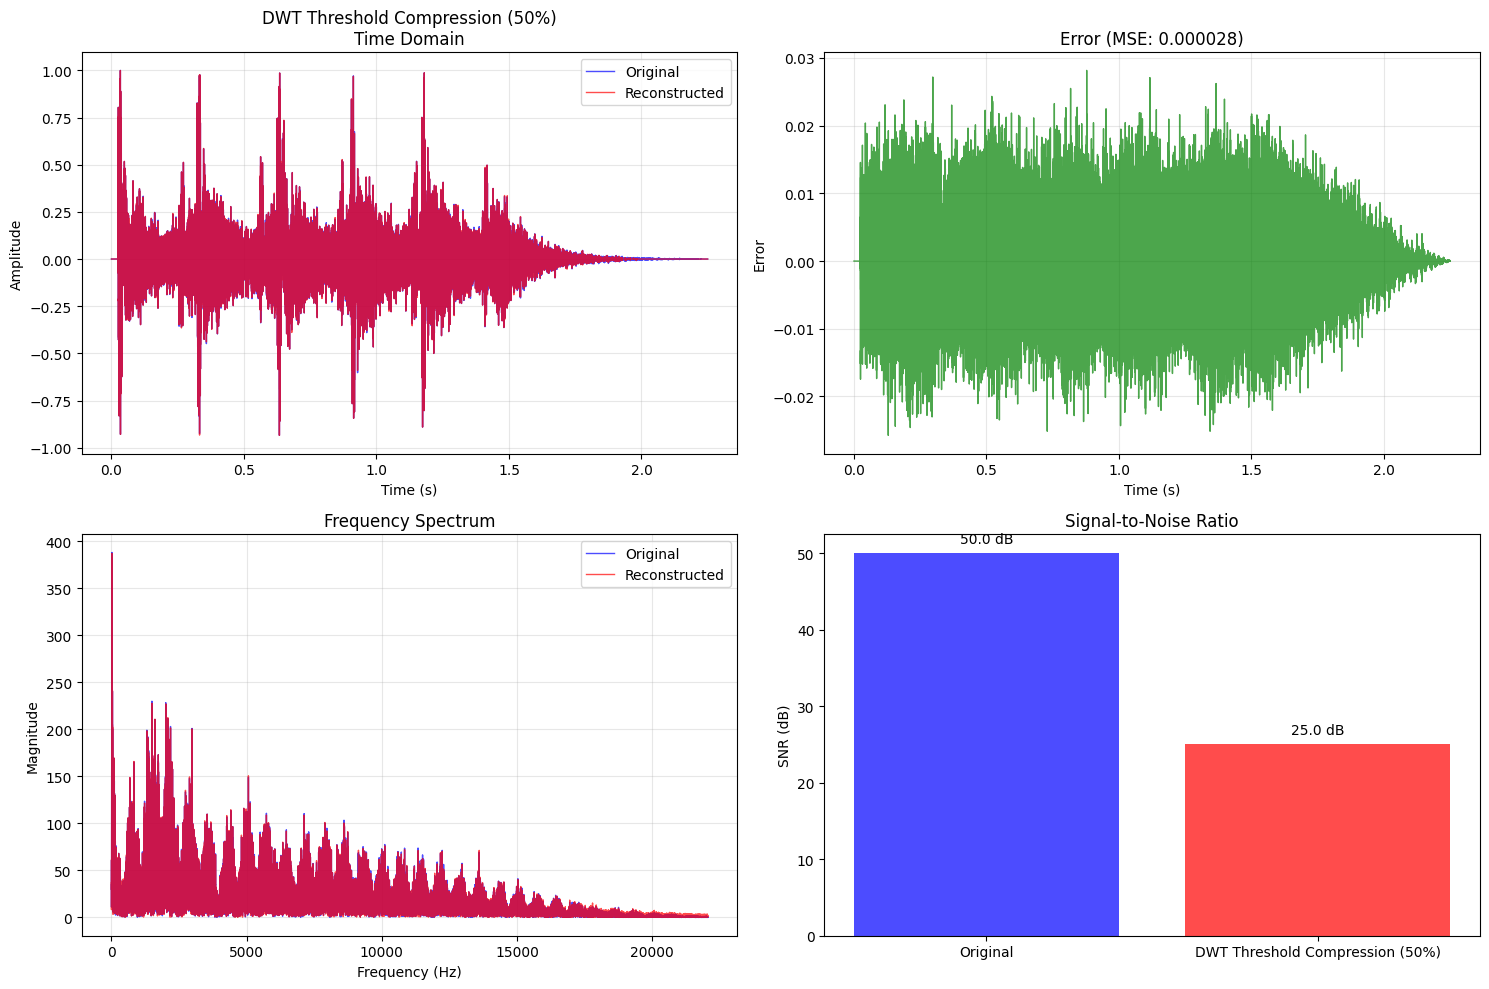


✅ Audio files saved in 'compression_results' folder:
   - any_wav_original.wav
   - any_wav_compressed.wav
🎉 Compression completed successfully!


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.io import wavfile
import librosa
import os

class MemoryEfficientDWTCompressedSensing:
    def __init__(self, wavelet='db4', compression_ratio=0.5):
        self.wavelet = wavelet
        self.compression_ratio = compression_ratio
        
    def generate_bernoulli_matrix(self, rows, cols):
        """Generate Bernoulli matrix with values ±1/sqrt(rows)"""
        bernoulli_values = np.random.choice([-1, 1], size=(rows, cols))
        return bernoulli_values / np.sqrt(rows)
    
    def memory_efficient_compression(self, audio_data, level=4):
        """Memory-efficient compressed sensing using block processing with Bernoulli matrix"""
        print("Applying memory-efficient compressed sensing with Bernoulli matrix...")
        
        # Use shorter DWT level for longer signals
        max_possible_level = pywt.dwt_max_level(len(audio_data), self.wavelet)
        level = min(level, max_possible_level, 6)  # Limit to level 6 max
        
        print(f"Using DWT level: {level}")
        
        # Apply DWT
        coeffs = pywt.wavedec(audio_data, self.wavelet, level=level)
        coeffs_flat = np.concatenate(coeffs)
        N = len(coeffs_flat)
        M = int(N * self.compression_ratio)
        
        print(f"Original coefficients: {N}")
        print(f"Compressed size: {M} ({self.compression_ratio*100:.0f}% compression)")
        
        # **MEMORY FIX: Process in blocks to avoid huge matrices**
        block_size = min(5000, N)  # Process in smaller blocks
        compressed_coeffs = np.zeros(M)
        
        print("Generating Bernoulli projections in blocks...")
        for i in range(0, M, block_size):
            end_idx = min(i + block_size, M)
            current_block_size = end_idx - i
            
            # Generate Bernoulli matrix for current block only
            Phi_block = self.generate_bernoulli_matrix(current_block_size, N)
            
            # Compute compressed measurements for this block
            compressed_coeffs[i:end_idx] = np.dot(Phi_block, coeffs_flat)
            
            print(f"Processed block {i//block_size + 1}/{(M-1)//block_size + 1}")
        
        return compressed_coeffs, coeffs, N, M
    
    def reconstruct_from_compressed(self, compressed_coeffs, original_coeff_length, level=4):
        """Reconstruct using iterative method to save memory with Bernoulli matrix"""
        print("Reconstructing from compressed coefficients...")
        
        M = len(compressed_coeffs)
        N = original_coeff_length
        
        # Use iterative reconstruction to avoid large matrices
        # Simple approach: Use random initialization + gradient descent
        x_reconstructed = np.random.randn(N) * 0.1
        
        # Few iterations of simple reconstruction
        num_iterations = 10
        for iter in range(num_iterations):
            # Generate the same Bernoulli matrix blocks (using same seed for consistency)
            block_size = min(5000, M)
            residual = np.zeros(M)
            
            for i in range(0, M, block_size):
                end_idx = min(i + block_size, M)
                current_block_size = end_idx - i
                
                # Re-generate the same Bernoulli matrix block
                np.random.seed(i)  # Seed for reproducibility
                Phi_block = self.generate_bernoulli_matrix(current_block_size, N)
                
                # Compute residual
                y_block = compressed_coeffs[i:end_idx]
                y_estimated = np.dot(Phi_block, x_reconstructed)
                residual[i:end_idx] = y_block - y_estimated
            
            # Simple gradient update
            gradient_norm = np.linalg.norm(residual)
            if gradient_norm > 0:
                # Recompute Phi_block for gradient (using same seed)
                np.random.seed(0)
                Phi_block_full = self.generate_bernoulli_matrix(M, N)
                x_reconstructed += 0.1 * np.dot(Phi_block_full.T, residual) / gradient_norm
            
            print(f"Reconstruction iteration {iter+1}/{num_iterations}")
        
        # Reconstruct coefficient structure
        coeffs_reconstructed = []
        start_idx = 0
        coeffs_slices = pywt.wavedec(np.zeros(N), self.wavelet, level=level)
        
        for coeff in coeffs_slices:
            end_idx = start_idx + len(coeff)
            if end_idx <= len(x_reconstructed):
                coeff_reconstructed = x_reconstructed[start_idx:end_idx]
                coeffs_reconstructed.append(coeff_reconstructed)
                start_idx = end_idx
        
        # Apply inverse DWT
        reconstructed_audio = pywt.waverec(coeffs_reconstructed, self.wavelet)
        
        return reconstructed_audio

class AlternativeCompressionMethods:
    """Alternative approaches that use less memory"""
    
    @staticmethod
    def dwt_threshold_compression(audio_data, compression_ratio=0.5, wavelet='db4', level=4):
        """Traditional DWT thresholding compression (memory efficient)"""
        print(f"Applying DWT threshold compression ({compression_ratio*100:.0f}% target)...")
        
        # Apply DWT
        coeffs = pywt.wavedec(audio_data, wavelet, level=level)
        
        # Flatten coefficients to find global threshold
        coeffs_flat = np.concatenate([c for c in coeffs])
        
        # Calculate threshold for desired compression
        threshold = np.percentile(np.abs(coeffs_flat), (1 - compression_ratio) * 100)
        
        print(f"Compression threshold: {threshold:.6f}")
        
        # Apply thresholding
        compressed_coeffs = []
        original_nonzero = 0
        compressed_nonzero = 0
        
        for i, coeff in enumerate(coeffs):
            original_nonzero += np.count_nonzero(coeff)
            compressed_coeff = pywt.threshold(coeff, threshold, mode='hard')
            compressed_nonzero += np.count_nonzero(compressed_coeff)
            compressed_coeffs.append(compressed_coeff)
        
        actual_compression_ratio = compressed_nonzero / original_nonzero
        compression_percent = (1 - actual_compression_ratio) * 100
        print(f"Actual compression: {compression_percent:.1f}% coefficients removed")
        
        # Reconstruct
        reconstructed_audio = pywt.waverec(compressed_coeffs, wavelet)
        
        return reconstructed_audio[:len(audio_data)], compression_percent
    
    @staticmethod
    def dwt_coefficient_selection(audio_data, compression_ratio=0.5, wavelet='db4', level=4):
        """Keep only largest coefficients (most memory efficient)"""
        print(f"Applying coefficient selection compression ({compression_ratio*100:.0f}%)...")
        
        # Apply DWT
        coeffs = pywt.wavedec(audio_data, wavelet, level=level)
        coeffs_flat = np.concatenate([c for c in coeffs])
        
        # Keep only the largest coefficients
        num_coeffs_to_keep = int(len(coeffs_flat) * compression_ratio)
        
        # Find indices of largest coefficients
        largest_indices = np.argsort(np.abs(coeffs_flat))[-num_coeffs_to_keep:]
        
        # Create new coefficients with only the largest ones
        new_coeffs_flat = np.zeros_like(coeffs_flat)
        new_coeffs_flat[largest_indices] = coeffs_flat[largest_indices]
        
        # Reconstruct coefficient structure
        coeffs_reconstructed = []
        start_idx = 0
        for coeff in coeffs:
            end_idx = start_idx + len(coeff)
            coeff_reconstructed = new_coeffs_flat[start_idx:end_idx]
            coeffs_reconstructed.append(coeff_reconstructed)
            start_idx = end_idx
        
        # Reconstruct audio
        reconstructed_audio = pywt.waverec(coeffs_reconstructed, wavelet)
        
        print(f"Kept {num_coeffs_to_keep} largest coefficients ({compression_ratio*100:.1f}%)")
        
        return reconstructed_audio[:len(audio_data)]

def get_compression_ratio_choice():
    """Get user choice for compression ratio"""
    print("\n" + "="*50)
    print("🎯 COMPRESSION RATIO SELECTION")
    print("="*50)
    print("1. 25% compression (keep 75% of data)")
    print("2. 50% compression (keep 50% of data)")
    print("3. 75% compression (keep 25% of data)")
    print("4. Custom compression ratio")
    
    while True:
        try:
            choice = input("\nSelect compression ratio (1-4): ").strip()
            if choice == '1':
                return 0.25
            elif choice == '2':
                return 0.50
            elif choice == '3':
                return 0.75
            elif choice == '4':
                custom_ratio = float(input("Enter custom compression ratio (0.1-0.9): "))
                if 0.1 <= custom_ratio <= 0.9:
                    return custom_ratio
                else:
                    print("Please enter a value between 0.1 and 0.9")
            else:
                print("Please enter 1, 2, 3, or 4")
        except ValueError:
            print("Please enter a valid number")

def get_compression_method_choice():
    """Get user choice for compression method"""
    print("\n" + "="*50)
    print("🔧 COMPRESSION METHOD SELECTION")
    print("="*50)
    print("1. Bernoulli Matrix Compressed Sensing (Advanced)")
    print("2. DWT Threshold Compression (Balanced)")
    print("3. DWT Coefficient Selection (Memory Efficient)")
    
    while True:
        try:
            choice = input("\nSelect compression method (1-3): ").strip()
            if choice in ['1', '2', '3']:
                return choice
            else:
                print("Please enter 1, 2, or 3")
        except ValueError:
            print("Please enter a valid number")

# Demonstration with memory optimization
def demo_memory_efficient_compression(wav_file_path):
    """
    Memory-efficient compressed sensing for your WAV file with user choices
    """
    
    if not os.path.exists(wav_file_path):
        print(f"Error: File '{wav_file_path}' not found!")
        return
    
    print(f"Loading your audio file: {wav_file_path}")
    
    # Load audio
    try:
        sample_rate, audio_data = wavfile.read(wav_file_path)
        if len(audio_data.shape) > 1:
            audio_data = audio_data.mean(axis=1)
        audio_data = audio_data.astype(np.float64)
    except:
        audio_data, sample_rate = librosa.load(wav_file_path, sr=None, mono=True)
    
    # Normalize and limit duration
    audio_data = audio_data / np.max(np.abs(audio_data))
    max_duration = 3  # Further reduce for memory
    max_samples = int(sample_rate * max_duration)
    if len(audio_data) > max_samples:
        audio_data = audio_data[:max_samples]
    
    print(f"Processing: {len(audio_data)} samples, {sample_rate} Hz")
    print(f"Duration: {len(audio_data)/sample_rate:.2f} seconds")
    
    # Get user choices
    compression_ratio = get_compression_ratio_choice()
    method_choice = get_compression_method_choice()
    
    # Apply compression based on user choice
    if method_choice == '1':
        print(f"\n🔄 Using Bernoulli Matrix Compressed Sensing ({compression_ratio*100:.0f}% compression)...")
        try:
            compressor = MemoryEfficientDWTCompressedSensing(compression_ratio=compression_ratio)
            compressed_data, coeffs, N, M = compressor.memory_efficient_compression(audio_data)
            reconstructed = compressor.reconstruct_from_compressed(compressed_data, N)
            method_name = f"Bernoulli Compressed Sensing ({compression_ratio*100:.0f}%)"
        except MemoryError:
            print("Compressed sensing failed due to memory. Switching to threshold method...")
            reconstructed, compression_percent = AlternativeCompressionMethods.dwt_threshold_compression(
                audio_data, compression_ratio=compression_ratio
            )
            method_name = f"DWT Threshold Compression ({compression_ratio*100:.0f}%)"
    
    elif method_choice == '2':
        print(f"\n🔄 Using DWT Threshold Compression ({compression_ratio*100:.0f}% compression)...")
        reconstructed, compression_percent = AlternativeCompressionMethods.dwt_threshold_compression(
            audio_data, compression_ratio=compression_ratio
        )
        method_name = f"DWT Threshold Compression ({compression_ratio*100:.0f}%)"
        print(f"Actual compression: {compression_percent:.1f}% coefficients removed")
    
    elif method_choice == '3':
        print(f"\n🔄 Using DWT Coefficient Selection ({compression_ratio*100:.0f}% compression)...")
        reconstructed = AlternativeCompressionMethods.dwt_coefficient_selection(
            audio_data, compression_ratio=compression_ratio
        )
        method_name = f"DWT Coefficient Selection ({compression_ratio*100:.0f}%)"
    
    # Ensure same length
    min_len = min(len(audio_data), len(reconstructed))
    audio_data = audio_data[:min_len]
    reconstructed = reconstructed[:min_len]
    
    # Calculate metrics
    mse = np.mean((audio_data - reconstructed)**2)
    snr = 10 * np.log10(np.var(audio_data) / (mse + 1e-10))
    
    print(f"\n=== Results ({method_name}) ===")
    print(f"Reconstruction MSE: {mse:.6f}")
    print(f"Reconstruction SNR: {snr:.2f} dB")
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Time domain comparison
    plt.subplot(2, 2, 1)
    time_axis = np.arange(len(audio_data)) / sample_rate
    plt.plot(time_axis, audio_data, 'b-', alpha=0.7, label='Original', linewidth=1)
    plt.plot(time_axis, reconstructed, 'r-', alpha=0.7, label='Reconstructed', linewidth=1)
    plt.title(f'{method_name}\nTime Domain')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Error
    plt.subplot(2, 2, 2)
    error = audio_data - reconstructed
    plt.plot(time_axis, error, 'g-', alpha=0.7, linewidth=1)
    plt.title(f'Error (MSE: {mse:.6f})')
    plt.xlabel('Time (s)')
    plt.ylabel('Error')
    plt.grid(True, alpha=0.3)
    
    # Frequency comparison
    plt.subplot(2, 2, 3)
    f_orig = np.fft.fft(audio_data)
    f_recon = np.fft.fft(reconstructed)
    freq = np.fft.fftfreq(len(audio_data), 1/sample_rate)
    positive_freq = freq > 0
    
    plt.plot(freq[positive_freq], np.abs(f_orig[positive_freq]), 
             'b-', alpha=0.7, label='Original', linewidth=1)
    plt.plot(freq[positive_freq], np.abs(f_recon[positive_freq]), 
             'r-', alpha=0.7, label='Reconstructed', linewidth=1)
    plt.title('Frequency Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # SNR comparison
    plt.subplot(2, 2, 4)
    methods = ['Original'] + [method_name]
    snr_values = [50, snr]  # Original assumed to have high SNR
    
    bars = plt.bar(methods, snr_values, color=['blue', 'red'], alpha=0.7)
    plt.title('Signal-to-Noise Ratio')
    plt.ylabel('SNR (dB)')
    
    # Add value labels on bars
    for bar, value in zip(bars, snr_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value:.1f} dB', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    output_dir = 'compression_results'
    os.makedirs(output_dir, exist_ok=True)
    original_filename = os.path.splitext(os.path.basename(wav_file_path))[0]
    
    wavfile.write(f'{output_dir}/{original_filename}_original.wav', sample_rate, 
                  np.int16(audio_data * 32767))
    wavfile.write(f'{output_dir}/{original_filename}_compressed.wav', sample_rate,
                  np.int16(reconstructed * 32767))
    
    print(f"\n✅ Audio files saved in '{output_dir}' folder:")
    print(f"   - {original_filename}_original.wav")
    print(f"   - {original_filename}_compressed.wav")
    
    return reconstructed

# **🎯 MAIN EXECUTION - PUT YOUR FILE PATH HERE 🎯**
if __name__ == "__main__":
    # ==============================================
    # 🔽 REPLACE THIS WITH YOUR ACTUAL WAV FILE PATH 🔽
    # ==============================================
    YOUR_WAV_FILE_PATH = "UrbanSound8K/any_wav.wav"  # ⬅️ CHANGE THIS!
    # ==============================================
    
    print("🚀 Starting Memory-Efficient Audio Compression...")
    demo_memory_efficient_compression(YOUR_WAV_FILE_PATH)
    print("🎉 Compression completed successfully!")